### The is a sentiment classification task for hotel reviews. There are 5 ratings that are the labels to be predicted based on the text in the reviews. 


In [1]:
import re
import nltk
from nltk.tag import pos_tag, map_tag
from itertools import dropwhile
import pandas as pd
import numpy as np
import collections


from nltk.corpus import CategorizedPlaintextCorpusReader

import random
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from wordcloud import WordCloud

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.feature_selection import chi2
import pickle
############################################################################### 
import matplotlib.pyplot as plt
import pandas_profiling as pp

from imblearn.over_sampling import SMOTE

import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\majed.aljefri\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\majed.aljefri\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\majed.aljefri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\majed.aljefri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Over sampling for minor classes,, ended up not using it as the classes were already almost balanced
def over_sample_SMOTE(X_train, y_train):
    sm=SMOTE(sampling_strategy='not majority', random_state=10) # 'minority'
    X_train_ovr, y_train_ovr=sm.fit_sample(X_train, y_train)

    #print(X_train_ovr.shape, y_train_ovr.shape)
    return X_train_ovr, y_train_ovr

In [4]:
#Mertics evluations
def evaluation(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    bl_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred, average='micro')
    recall=recall_score(y_test, y_pred, average='micro')
    f1=f1_score(y_test, y_pred, average='micro')
    
    return accuracy, precision, recall, f1

In [5]:
def print_evlauation(y_test, y_pred):
    accuracy, precision, recall, f1 = evaluation(y_test, y_pred)
    print('accuracy {:.2f}, precision {:.2f}, recall {:.2f}, f1 {:.2f}'.format(accuracy, precision, recall, f1))
    

In [6]:
#feature selection 
def select_k_features(X_train,X_test,y_train,k):
    selection = SelectKBest(chi2, k)
    X_train = selection.fit_transform(X_train,y_train)
    X_test = selection.transform(X_test)
    
    return selection, X_train, X_test

In [7]:
def draw_conf_matrix(conf_matrix): 
    
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(conf_matrix,
                     annot= True, 
                     fmt = '.4g', 
                     cbar=0,
                     xticklabels=['1 star','2 stars','3 stars','4 stars','5 stars'],
                     yticklabels=['1 star','2 stars','3 stars','4 stars','5 stars'])
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

In [9]:
def show_wordcloud(data, title = None): 
    wordcloud = WordCloud( collocations=False,
        background_color='black',
        stopwords=set(stop_words),
        max_words=80,
        max_font_size=60, 
        scale=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [10]:
def get_allwords(df):
    corpus = []
    
    for index, row in df.iterrows():
        tokens = nltk.word_tokenize(row['review'])
    
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        words = [w for w in tokens if w not in string.punctuation]

        # remove remaining tokens that are not alphabetic
        words = [w for w in words if w.isalpha()]

        # filter out stop words
        words = [w for w in words if not w in stop_words]
    
        corpus.append(words)
        
        return corpus

In [51]:
train_file = 'C:/Side Projects/Chata ai/data/sentiment_dataset_train.csv'
df = pd.read_csv(train_file, encoding='utf-8')
# one raw has wrong value (text as label). this was manually removed

In [52]:
df.shape

(35004, 3)

In [53]:
df.head()

,id,review,rating
0,0,Arrived about 10pm and check in was painless. ...,4
1,1,I checked in at 4pm even tough room was not re...,2
2,2,"I chose this hotel, as it was in a good locati...",2
3,3,"Great location, super close to shops & a 10min...",4
4,4,I was in the Sir Adam Hotel to visit a friend....,3


#### Find and draw distribution of the classes 

In [54]:
#check number of samples per class
count = df['rating'].value_counts() 
print(count)

2    7031
1    7028
4    6997
5    6977
3    6971
Name: rating, dtype: int64


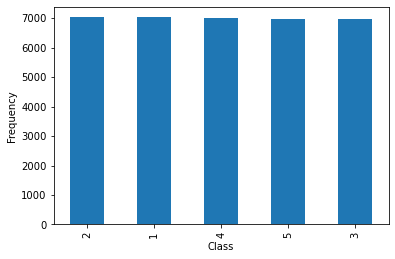

In [55]:
fig, ax = plt.subplots()
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
df['rating'].value_counts().plot(ax=ax, kind='bar')

In [14]:
report = pp.ProfileReport(df)
report.to_file('C:/Side Projects/Chata ai/profile_report.html')

In [56]:
# some nltk helpers
import string 
porter = PorterStemmer()
stop_words = stopwords.words('english') 
stemmer = PorterStemmer() 
lemmatizer = WordNetLemmatizer()

#### Preprocess the data

In [57]:
def preprocess_text(row):
    tokens = nltk.word_tokenize(row['review'])
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    words = [w for w in tokens if w not in string.punctuation]
    
    # remove remaining tokens that are not alphabetic
    words = [w for w in words if w.isalpha()]
    
    # filter out stop words
    words = [w for w in words if not w in stop_words]
   
    #stems = [porter.stem(word) for word in words]
    lemmas =[lemmatizer.lemmatize(word) for word in words]
                   
    #return ' '.join(stems)
    return ' '.join(lemmas)


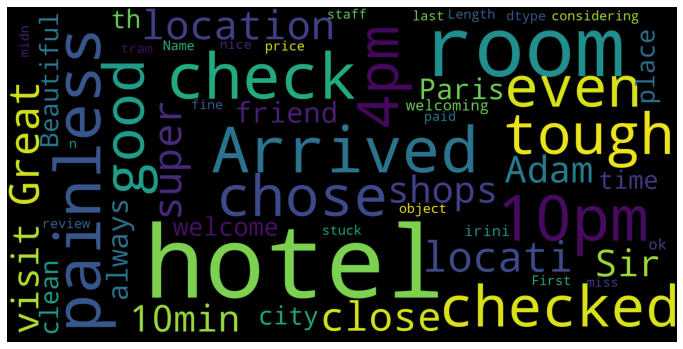

In [58]:
# Draw word cloud for all words before normalization 
show_wordcloud(df['review'])

In [59]:
# Apply preprocessing to all reviews
df['review'] = df.apply(lambda row: preprocess_text(row), axis=1)

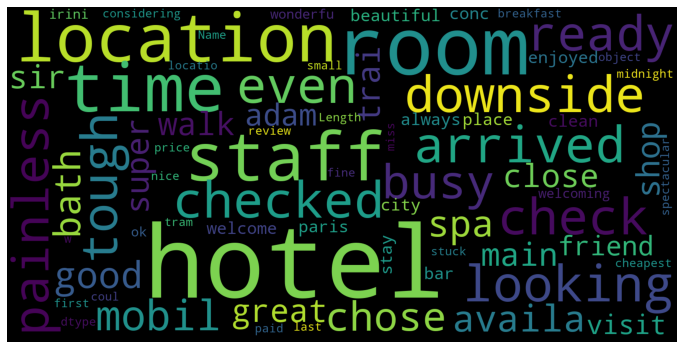

In [60]:
# Draw word cloud for after normalization 
show_wordcloud(df['review'])

In [61]:
#get reviews' lengths for data exploration 
df['review length']= df['review'].str.len() 
rev_ln = df['review length'].describe()
print(rev_ln)

count    35004.000000
mean       321.172952
std        136.038517
min          4.000000
25%        192.000000
50%        321.000000
75%        444.000000
max       2561.000000
Name: review length, dtype: float64


(array([12.,  0.,  0., ...,  0.,  0.,  0.]),
 array([   4,    5,    6, ..., 2558, 2559, 2560]),
 <a list of 2556 Patch objects>)

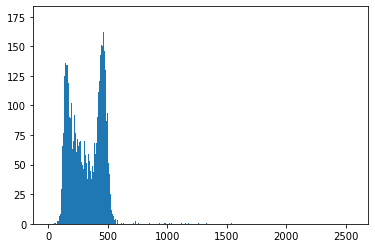

In [62]:
plt.hist(df['review length'], bins=np.arange(df['review length'].min(), df['review length'].max()))

In [83]:
# apply tfidf for feature extraction 
cv = TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True, max_features  = 5000)
        
X = np.array(df['review'])
y = np.array(df['rating'])

X = cv.fit_transform(X) 

In [84]:
#apply feature selection, 
#selection, X_train, X_test = select_k_features(X_train,X_test,y_train,5000)
#X_train, y_train = over_sample_SMOTE(X_train, y_train)

In [85]:
dev_file = 'C:/Side Projects/Chata ai/data/sentiment_dataset_dev.csv'

df_dev = pd.read_csv(dev_file, encoding='utf-8')
df_dev['review'] = df_dev.apply(lambda row: preprocess_text(row), axis=1)

X_dev = np.array(df_dev['review'])
y_dev = np.array(df_dev['rating'])

X_dev = cv.transform(X_dev)
#X_dev = selection.transform(X_dev)

#### Baseline (Decision Tree)

Confusion Matrix:
[[888 376 152  69  38]
 [367 648 303 124  65]
 [170 313 627 241 132]
 [ 65 143 253 702 337]
 [ 41 105 151 337 852]]

Evaluation Metrics
accuracy 0.50, precision 0.50, recall 0.50, f1 0.50


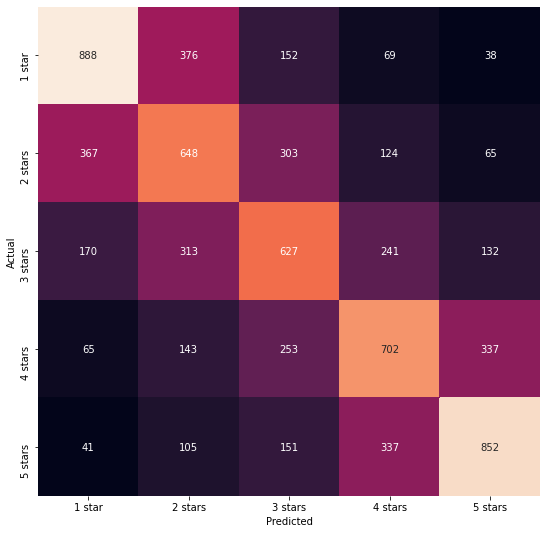

In [86]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)
y_dev_pred = dt_clf.predict(X_dev)
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_dev_pred))
print('')
print('Evaluation Metrics')
print_evlauation(y_dev, y_dev_pred)
draw_conf_matrix(confusion_matrix(y_dev, y_dev_pred))

In [87]:
target_names = ['1 star','2 stars','3 stars','4 stars','5 stars']
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

      1 star       0.58      0.58      0.58      1523
     2 stars       0.41      0.43      0.42      1507
     3 stars       0.42      0.42      0.42      1483
     4 stars       0.48      0.47      0.47      1500
     5 stars       0.60      0.57      0.59      1486

    accuracy                           0.50      7499
   macro avg       0.50      0.50      0.50      7499
weighted avg       0.50      0.50      0.50      7499



#### Logistic Regression (Best model)¶

In [88]:
lr_param_grid = {'C': [0.1, 1, 10],          
              'max_iter':[100, 200],
              'penalty': [ 'l2', None],
  }

In [89]:
lr_clf = LogisticRegression()
lr_grid_search = GridSearchCV(lr_clf, param_grid=lr_param_grid, cv=5 , n_jobs = -1)
lr_grid_search.fit(X, y)
#rid_search.best_estimator_.get_params()

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l2', None]})

Confusion Matrix:
[[1252  209   42    8   12]
 [ 270 1013  188   30    6]
 [  53  192 1085  129   24]
 [  10   40  158 1090  202]
 [   8   14   47  268 1149]]

Evaluation Metrics
accuracy 0.75, precision 0.75, recall 0.75, f1 0.75


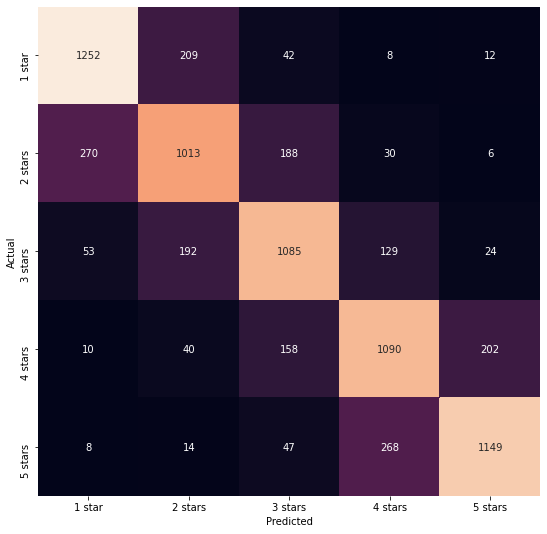

In [90]:
y_dev_pred = lr_grid_search.best_estimator_.predict(X_dev)
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_dev_pred))
print('')
print('Evaluation Metrics')
print_evlauation(y_dev, y_dev_pred)
draw_conf_matrix(confusion_matrix(y_dev, y_dev_pred))

In [91]:
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

      1 star       0.79      0.82      0.80      1523
     2 stars       0.69      0.67      0.68      1507
     3 stars       0.71      0.73      0.72      1483
     4 stars       0.71      0.73      0.72      1500
     5 stars       0.82      0.77      0.80      1486

    accuracy                           0.75      7499
   macro avg       0.75      0.75      0.75      7499
weighted avg       0.75      0.75      0.75      7499



#### Random Forest Classifier

In [33]:
rf_param_grid = {'max_depth' : [15, 30],
              'criterion' : ['gini','entropy'],
              'n_estimators': [100, 200],           
  }

In [34]:
rf_clf = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_clf, param_grid=rf_param_grid, cv=5, n_jobs = -1)
rf_grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 30], 'n_estimators': [100, 200]})

Confusion Matrix:
[[1266  182   33   21   21]
 [ 475  795  153   55   29]
 [ 145  238  832  193   75]
 [  37   58  145 1022  238]
 [  26   27   55  311 1067]]

Evaluation Metrics
accuracy 0.66, precision 0.66, recall 0.66, f1 0.66


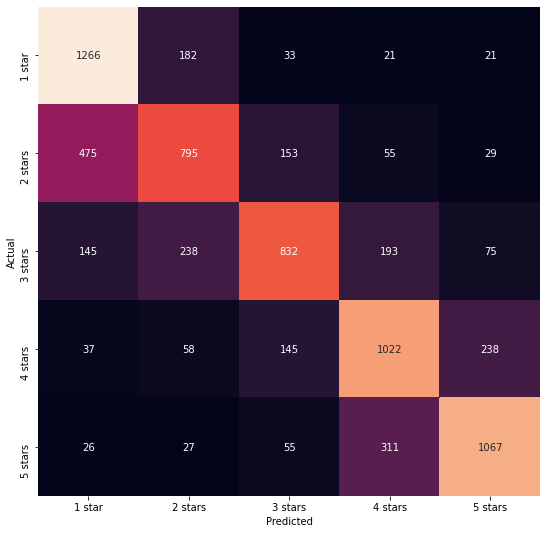

In [35]:
y_dev_pred = rf_grid_search.best_estimator_.predict(X_dev)
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_dev_pred))
print('')
print('Evaluation Metrics')
print_evlauation(y_dev, y_dev_pred)
draw_conf_matrix(confusion_matrix(y_dev, y_dev_pred))

In [36]:
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

      1 star       0.65      0.83      0.73      1523
     2 stars       0.61      0.53      0.57      1507
     3 stars       0.68      0.56      0.62      1483
     4 stars       0.64      0.68      0.66      1500
     5 stars       0.75      0.72      0.73      1486

    accuracy                           0.66      7499
   macro avg       0.67      0.66      0.66      7499
weighted avg       0.67      0.66      0.66      7499



#### XGBoost Classifier

In [37]:
xgb_param_grid = {'max_depth' : [15, 30],
                  'n_estimators': [100, 200], 
                 'learning_rate': [0.05, 0.1],
  }                 

In [38]:
xgb_clf = XGBClassifier()
xgb_grid_search = GridSearchCV(xgb_clf, param_grid=xgb_param_grid, cv=5, n_jobs = -1)
xgb_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Confusion Matrix:
[[1200  238   54   17   14]
 [ 263 1003  194   32   15]
 [  64  194 1068  134   23]
 [  15   46  202 1038  199]
 [  10   20   61  275 1120]]

Evaluation Metrics
accuracy 0.72, precision 0.72, recall 0.72, f1 0.72


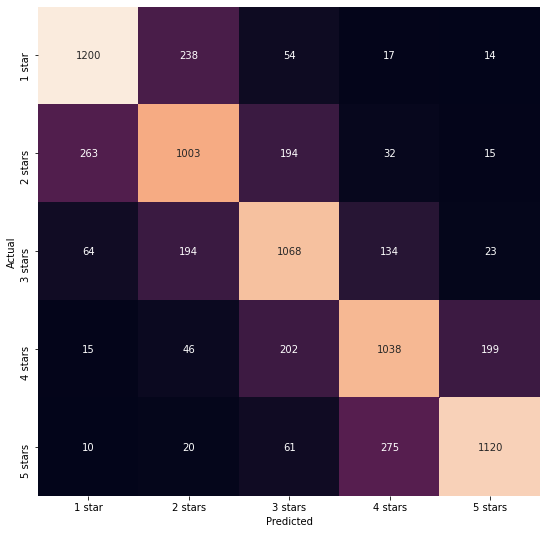

In [40]:
y_dev_pred = xgb_grid_search.best_estimator_.predict(X_dev)
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_dev_pred))
print('')
print('Evaluation Metrics')
print_evlauation(y_dev, y_dev_pred)
draw_conf_matrix(confusion_matrix(y_dev, y_dev_pred))

In [42]:
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

      1 star       0.77      0.79      0.78      1523
     2 stars       0.67      0.67      0.67      1507
     3 stars       0.68      0.72      0.70      1483
     4 stars       0.69      0.69      0.69      1500
     5 stars       0.82      0.75      0.78      1486

    accuracy                           0.72      7499
   macro avg       0.73      0.72      0.72      7499
weighted avg       0.73      0.72      0.72      7499



#### CatBoost Classifier (very slow)

In [26]:
cb_clf = CatBoostClassifier(verbose= False)
cb_clf.fit(X, y)
y_dev_pred = cb_clf.predict(X_dev)
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_dev_pred))
print('')
print('Evaluation Metrics')
print_evlauation(y_dev, y_dev_pred)
draw_conf_matrix(confusion_matrix(y_dev, y_dev_pred))

[[1171  192   26    7   10]
 [ 284  907  179   28    8]
 [  86  151  981  125   51]
 [  19   38  172  997  174]
 [  17   15   36  275 1052]]
accuracy 0.73, precision 0.73, recall 0.73, f1 0.73
accuracy 0.73, precision 0.73, recall 0.73, f1 0.73


In [ ]:
print(classification_report(y_test, y_dev_pred, target_names=target_names))

#### Model Prediction on the dev and test data

In [29]:
#save dev set prediction 
df_dev['prediction'] = np.array(y_dev_pred)
df_dev.to_csv('C:/Side Projects/Chata ai/data/dev_predictions.csv', encoding='utf-8')

In [30]:
#load test set and make predictions
test_file = 'C:/Side Projects/Chata ai/data/sentiment_dataset_test.csv'

df_test = pd.read_csv(test_file, encoding='utf-8')

#preprocess reviews
df_test['review'] = df_test.apply(lambda row: preprocess_text(row), axis=1)

X_test = np.array(df_test['review'])

X_test = cv.transform(X_test)
#X_dev = selection.transform(X_dev)

#make prediction
y_test_pred = lr_grid_search.best_estimator_.predict(X_test)

#save predictions 
df_test['prediction'] = np.array(y_test_pred)
df_test.to_csv('C:/Side Projects/Chata ai/data/test_predictions.csv', encoding='utf-8')

#### Using Shap to explore the top features used by the tree based classifier (very slow)

In [66]:
explainer = shap.TreeExplainer(rf_grid_search.best_estimator_)
shap_values = explainer.shap_values(X.toarray())

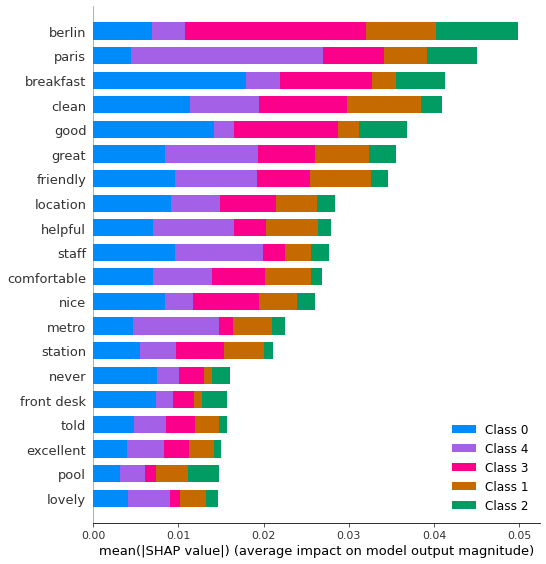

In [67]:
file_name = 'C:/Side Projects/Chata ai/data/sentiment_dataset_dev.png'

shap.summary_plot(shap_values, X,plot_type="bar", feature_names = cv.get_feature_names(), show=False)
plt.savefig(file_name,dpi=300,bbox_inches='tight')

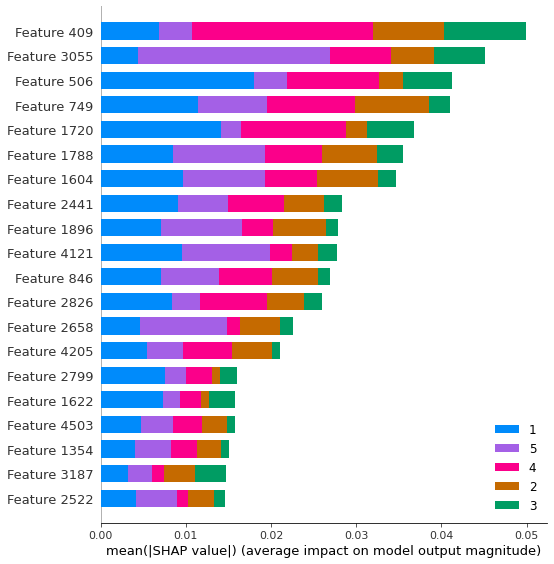

In [69]:
shap.summary_plot(shap_values, X,plot_type="bar", show=False, class_names=rf_grid_search.best_estimator_.classes_)

In [70]:
file_name = 'C:/Side Projects/Chata ai/data/Shap_feature.png'
plt.savefig(file_name,dpi=300,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [73]:
file_name2 = 'C:/Side Projects/Chata ai/data/TopFeatures.txt'

sorter = np.argsort((shap_values))

n = 100 # this is number of features top
sorter = np.append(sorter[:n],sorter[-n:]) #this is fixed code
features = cv.get_feature_names()

text_file = open(file_name2, "w")

for i in sorter[:n]:
    text_file.write('%s\n'% features[i])

text_file.close()

### Save the best model

In [32]:
model_file = 'C:/Side Projects/Chata ai/model.pickle'
pickle.dump([dt_clf, lr_grid_search.best_estimator_, cv], open(model_file, 'wb'))

## Additional Classification (Three class classification)

### Here I relabled the data so that reviews 1 and 2 are considered bad, 4 and 5 as good, and 3 is nutral .. This results in new three classes


In [43]:
# sentiment analysis.

def get_class(score):
    score = int(score)
    if score > 3:
        return 1
    elif score <3:
        return -1
    else:
        return 0



In [44]:
df2 = df
df2['label'] = df2['rating'].apply(get_class)

df_dev2 = df_dev
df_dev2['label'] = df_dev2['rating'].apply(get_class)

In [45]:
cv = TfidfVectorizer(ngram_range=(1, 3), sublinear_tf  =True, max_features  = 5000)
 
X = np.array(df2['review'])
y = np.array(df2['label'])

X_dev = np.array(df_dev2['review'])
y_dev = np.array(df_dev2['label'])

X = cv.fit_transform(X) 
X_dev = cv.transform(X_dev)

In [46]:
rl_clf = LogisticRegression()
rl_clf.fit(X, y)
y_dev_pred = rl_clf.predict(X_dev)
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_dev_pred))
print('')
print('Evaluation Metrics')
print_evlauation(y_dev, y_dev_pred)

Confusion Matrix:
[[2813  159   58]
 [ 300  978  205]
 [  80  130 2776]]

Evaluation Metrics
accuracy 0.88, precision 0.88, recall 0.88, f1 0.88


In [50]:
target_names = ['good','nutral','bad']
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

        good       0.88      0.93      0.90      3030
      nutral       0.77      0.66      0.71      1483
         bad       0.91      0.93      0.92      2986

    accuracy                           0.88      7499
   macro avg       0.86      0.84      0.85      7499
weighted avg       0.87      0.88      0.87      7499

